<a href="https://colab.research.google.com/github/giorgianav/PracticalSessions/blob/master/Copy_of_mps_machine_learning_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Some basic imports
import numpy as np
import pandas as pd
import io
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# For the dataset file upload
from google.colab import files

# For unpacking the archive
%pip install pyunpack
%pip install patool
from pyunpack import Archive

# For the neural network model
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
import tensorflow as tf

# For visualization
import matplotlib.pyplot as plt

# Other imports
import math
import glob
import csv
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 9.7 MB/s eta 0:00:00


# 1. Global solution

The global solution of the project.

Because uploading the global archive directly would take way too much time in Google Collab, we use an additional preprocessed Excel file.

The Excel is an input file with all the inputs taken and put together. Each row represents one input value (one `csv` file from the given image files in the problem archive).

The first column represents the `ideal threshold` value, the next 15 columns represent `the algorithms threshold` values, and the next 256 values represent the `f-measure` values for each input.

The input file **MUST** be called `global-inputs.xlsx` and contain the columns described above.

## 1.1 Generating the input file

The cell below represents an example of a function that takes as input a directory containing input images in the form of `csv` files (like those given in the archive of the problem), and outputs the `global-inputs.xlsx` file, suitable as input to this program.

What needs to be done to run this piece of code is simply copy paste in a Python file, put the (unarchived) global archive somewhere in a directory, and call the function accordingly (`generate_global_excel_file(<path_to_global_images>)`.

**Note:** You probably want to run this in a local environment to get the Excel file, uploading the `csv` files to Google Collab is definitely not an option.

In [ ]:
import glob
import csv
import math

# openpyxl is needed as a package
import openpyxl
from openpyxl import Workbook

def generate_global_excel_file(global_files_dir):
    # Create a spreadsheet
    workbook = Workbook()
    sheet = workbook.active

    # Parse every CSV file
    for index, file_name in enumerate(glob.glob(global_files_dir + "/*.CSV")):
        with open(file_name, "r") as file:
            csvfile = list(csv.reader(file))

            # 16 thresholds (1 ideal + 15 others)
            thresholds = csvfile[0]

            # 256 f-measures
            f_measures = csvfile[1]
            f_measures = f_measures[:-1] # the last value is an empty value

            # Combine the 2 rows into a single row
            input_row = thresholds
            input_row.extend(f_measures)

            # Append the row to the Excel file
            for j in range(len(input_row)):
                cell = sheet.cell(row=index+1, column=j+1)
                cell.value = float(input_row[j])

    # Save the spreadsheet
    workbook.save(filename="global-inputs.xlsx")

## 1.2 The solution

The actual solution is not very difficult to understand.

First of all, why machine learning? Well, the inputs to predict and the values used to train the machine learning model are between 0 and 1, which are just absolutely perfect inputs for such a use-case. The machine learning model easily trains on inputs between 0 and 1, close to one another, with an even distribution. Also, there is quite a huge input set (19120 images) to train on, so the more the better.

Now, to explain the solution and the machine learning model. The inputs are split between training and testing in a .7/.3 ratio. The model is a very simple regression neural network with 3 layers, all containing 512 neurons, and a final output layer with 1 neuron. Of course, the performance could be improved by trying different widths or heights of the network, but we found this to work decently well. The neural network is trained with 100 epochs and a batch size of 100 images at a time. These parameters could also be hyper-tuned to obtain better performance. The metric used to train the model is `mean squared error` between the predicted value and the actual value. The lower the better.

The program also contains a few interesting graphs with the results, as well as % accuracy.

Some of the problems of the model could, of course, be overfitting or underfitting, however the results (which is a test set of 30% of the total images in the input) show promising values.

In [ ]:
# Upload the dataset file, must be called 'global-inputs.xlsx'
dataset = files.upload()

# Process the dataset file into a pandas dataframe
dataset_df = pd.read_excel(io.BytesIO(dataset['global-inputs.xlsx']), header=None)

# The data we are going to work with
dataset_df

MessageError: ignored

In [ ]:
# Get the features as the columns, except the first one
features = dataset_df.columns[1:16]
features = dataset_df[features]

features

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.449020,0.449020,0.416978,0.692157,0.693906,0.715686,0.476471,0.692436,0.449020,0.570588,0.578431,0.578336,0.539216,0.574510,0.629412
1,0.656863,0.723529,0.624919,0.668627,0.823212,0.849020,0.472549,0.829980,0.652941,0.703922,0.758824,0.758641,0.841176,0.758824,0.778431
2,0.605882,0.617647,0.573581,0.617647,0.798840,0.825490,0.613725,0.798150,0.598039,0.660784,0.711765,0.711765,0.449020,0.711765,0.747059
3,0.570588,0.570588,0.528074,0.641176,0.767999,0.798039,0.574510,0.771589,0.558824,0.613725,0.676471,0.676471,0.417647,0.676471,0.711765
4,0.527451,0.527451,0.487351,0.609804,0.747547,0.774510,0.539216,0.744172,0.511765,0.625490,0.645098,0.645098,0.386275,0.645098,0.684314
5,0.488235,0.488235,0.450499,0.707843,0.716547,0.739216,0.503922,0.712562,0.472549,0.594118,0.609804,0.609804,0.370588,0.609804,0.656863
6,0.413725,0.413725,0.386716,0.664706,0.669724,0.696078,0.468627,0.665107,0.413725,0.543137,0.547059,0.547059,0.523529,0.547059,0.605882
7,0.425490,0.366667,0.359007,0.641176,0.646560,0.688235,0.460784,0.641589,0.382353,0.519608,0.519608,0.523428,0.496078,0.519608,0.578431
8,0.617647,0.335294,0.333648,0.625490,0.627294,0.652941,0.433333,0.622160,0.354902,0.496078,0.496078,0.495979,0.480392,0.492157,0.558824
9,0.605882,0.303922,0.310470,0.609804,0.608883,0.633333,0.433333,0.606691,0.327451,0.484314,0.468627,0.468627,0.464706,0.468627,0.535294


In [ ]:
# Get the first column as the target column to predict
target = dataset_df[0]

target

0        0.484314
1        0.696078
2        0.645098
3        0.601961
4        0.558824
           ...   
19115    0.647634
19116    0.630368
19117    0.613914
19118    0.597547
19119    0.581840
Name: 0, Length: 19120, dtype: float64

In [ ]:
# Get the f-measures as the rest of the columns
f_measures = dataset_df.columns[16:]
f_measures = dataset_df[f_measures]

f_measures

,16,17,18,19,20,21,22,23,24,25,...,262,263,264,265,266,267,268,269,270,271
0,0.00219,0.00219,0.00438,0.00438,0.008761,0.010951,0.013141,0.013141,0.013141,0.019710,...,3.077253,3.077231,3.077215,3.077187,3.077169,3.077151,3.077133,3.077119,3.077112,3.077102
1,0.00219,0.00219,0.00219,0.00219,0.002190,0.002190,0.002190,0.002190,0.002190,0.002190,...,3.077523,3.077441,3.077377,3.077310,3.077253,3.077215,3.077169,3.077133,3.077112,3.077102
2,0.00219,0.00219,0.00219,0.00219,0.002190,0.002190,0.002190,0.002190,0.002190,0.002190,...,3.077441,3.077377,3.077310,3.077280,3.077231,3.077187,3.077169,3.077133,3.077112,3.077102
3,0.00219,0.00219,0.00219,0.00219,0.002190,0.002190,0.002190,0.002190,0.002190,0.004380,...,3.077377,3.077310,3.077280,3.077231,3.077215,3.077169,3.077151,3.077133,3.077112,3.077102
4,0.00219,0.00219,0.00219,0.00219,0.002190,0.004380,0.004380,0.004380,0.004380,0.008761,...,3.077310,3.077280,3.077253,3.077215,3.077187,3.077169,3.077151,3.077119,3.077112,3.077102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19115,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321
19116,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321
19117,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321
19118,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321,4.892321


In [ ]:
# Split the dataset into train and test
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [ ]:
# Create the neural network model
network = models.Sequential()
network.add(layers.Dense(units=512, activation="relu", input_dim=len(features.columns)))
network.add(layers.Dense(units=512, activation="relu"))
network.add(layers.Dense(units=512, activation="relu"))
network.add(layers.Dense(units=1, activation="sigmoid"))

In [ ]:
# Compile the neural network
network.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [ ]:
# Train the neural network
hist = network.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=1, batch_size=500)

Epoch 1/50
22/22 [==============================] - 2s 54ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 2/50
22/22 [==============================] - 1s 44ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 3/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 4/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 5/50
22/22 [==============================] - 1s 40ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 6/50
22/22 [==============================] - 1s 41ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 7/50
22/22 [================

In [ ]:
# Predict using the test set
predicted_target = network.predict(x_test)

predicted_target = pd.Series(predicted_target.flatten(), index=y_test.index)

predicted_target

180/180 [==============================] - 1s 4ms/step


7781     0.552820
18852    0.815192
7932     0.388313
18519    0.502509
3651     0.603589
           ...   
16612    0.591421
14759    0.406743
10824    0.373140
5787     0.002203
4130     0.868975
Length: 5736, dtype: float32

In [ ]:
# Sort the test results on the y indices
y_test.sort_index(axis=0, inplace=True)

y_test

0        0.484314
3        0.601961
5        0.519608
6        0.460784
8        0.413725
           ...   
19095    0.629412
19107    0.829412
19111    0.723529
19116    0.630368
19118    0.597547
Name: 0, Length: 5736, dtype: float64

In [ ]:
# Sort the prediction results on the y indices
predicted_target.sort_index(axis=0, inplace=True)

predicted_target

0        0.446101
3        0.593569
5        0.570287
6        0.430242
8        0.408808
           ...   
19095    0.674877
19107    0.815158
19111    0.717490
19116    0.615084
19118    0.578885
Length: 5736, dtype: float32

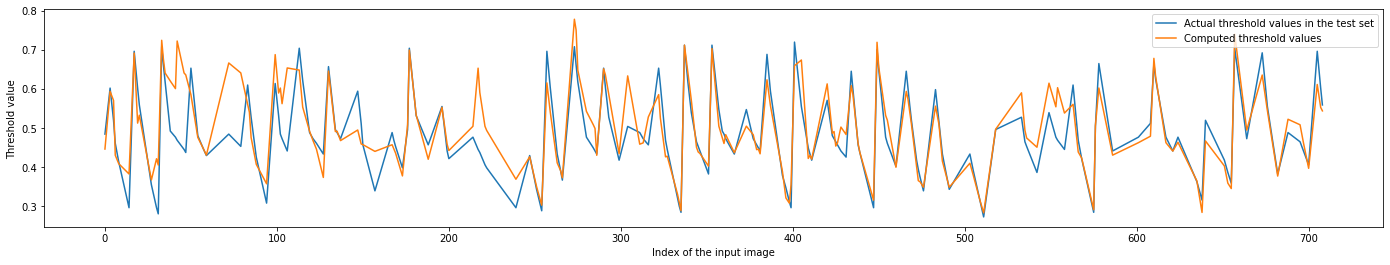

In [ ]:
# Plot the results onto a graph
plt.figure(figsize=(24, 4))
plt.plot(y_test[0:200])
plt.plot(predicted_target[0:200])
plt.legend(["Actual threshold values in the test set", "Computed threshold values"])
plt.xlabel("Index of the input image")
plt.ylabel("Threshold value")
plt.show()

In [ ]:
# Evaluate how many of the test set results are within x% accuracy

# helper method: get an f_measure value given the current threshold and
# the f measures array
def get_fmeasure_value(threshold, f_measures_array):
  fmeasure_index = math.floor(float(threshold) * 255)
  f_measures_array.reset_index(inplace=True, drop=True) # reset index to 0, 255
  return float(f_measures_array[fmeasure_index])


# helper method: given a target accuracy, return the total numbers of predicted
# values that are above that accuracy
def get_accuracy_percent(target_acc):

  total = 0

  # iterate on every predicted value
  for index, value in predicted_target.iteritems():

    # get the current f_measure float value
    current_fm = get_fmeasure_value(value, f_measures.iloc[index])

    # get the ideal f_measure in the f_measures array
    ideal_fm = max(f_measures.iloc[index])

    # calculate the error / accuracy
    accuracy = abs(current_fm / ideal_fm) if ideal_fm > 0 else 0

    # if accuracy > x%, add to the total
    if accuracy > target_acc:
      total = total + 1

  return total


# iterate over a list of accuracies
acc_list = [.60, .70, .80, .85, .90, .95, .99]
for acc in acc_list:
  print(f"{get_accuracy_percent(acc)} of the predicted values out of the total of {len(y_test)} test images are above {acc} percent accuracy")

5452 of the predicted values out of the total of 5736 test images are above 0.6 percent accuracy
5293 of the predicted values out of the total of 5736 test images are above 0.7 percent accuracy
5104 of the predicted values out of the total of 5736 test images are above 0.8 percent accuracy
4960 of the predicted values out of the total of 5736 test images are above 0.85 percent accuracy
4681 of the predicted values out of the total of 5736 test images are above 0.9 percent accuracy
4131 of the predicted values out of the total of 5736 test images are above 0.95 percent accuracy
2406 of the predicted values out of the total of 5736 test images are above 0.99 percent accuracy


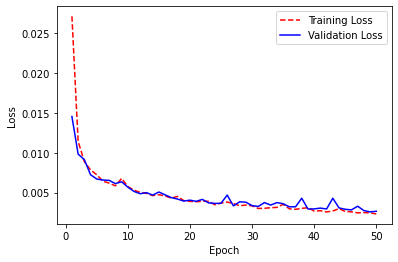

In [ ]:
# Visualize loss history

# Get training and validation loss histories
loss = hist.history["loss"]
validation_loss = hist.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(loss) + 1)

# Plot the results
plt.plot(epoch_count, loss, "r--")
plt.plot(epoch_count, validation_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Network loss
loss, _ = network.evaluate(x_test, y_test)
print(f"Network loss: {loss}")

180/180 [==============================] - 1s 4ms/step - loss: 0.1118 - mean_squared_error: 0.1118
Network loss: 0.11177010834217072


# 2. Local solution

The local solution of the project.

The local solution is very similar to the global solution, except the accuracy of the neural network will be decided by a binary calculation (0 and 1), rather than an f measure.

The input files are organized a bit different for the local solution. The first column represents the `ideal threshold`, the second column represents the `white/black value` of the pixel (0/1), and the next 10 columns represent `the algorithms thresholds`.

The input archive **MUST** be called `mps-local.7z` and contain the columns described above.

## 2.1 Uploading the input files

This time around, the archive `mps-local.7z` (the one from the problem) can be directly uploaded (though careful, it's quite big so it takes a while).

After that, each file is parsed (again, might take a while), and added to a data frame.

Because there are almost 1200 images containing close to 10 million pixels, a generator is defined that reads batches of 50 images and feeds them to the neural network training algorithm. This way, we don't run out of RAM memory.

In [ ]:
local_archive = files.upload()

# Unarchive the local archive file
Archive('mps-local.7z').extractall('/content/')

Saving mps-local.7z to mps-local.7z


In [ ]:
# Define a generator to feed batches to the neural network
def generate_batch_of_images():

  # Parse every CSV file
  tmp_lst = []
  for index, file_name in enumerate(glob.glob("/content/MPS-Local/*.CSV")):
    with open(file_name, "r") as file:
      csvfile = list(csv.reader(file))

      if index != 0 and index % 50 == 0:
        
        # The local dataset
        dataset_local_df = pd.DataFrame(tmp_lst, columns=range(0, 12), dtype=float)

        # Get the features as the columns
        features = dataset_local_df.columns[2:12]
        features = dataset_local_df[features]

        # Get the second column as the target column to predict (binary, 0 and 1)
        target = dataset_local_df[1]

        # Yield the current batch of 50 images
        yield features, target

        # Refresh the accumulator list
        tmp_lst = []

      tmp_lst.extend(csvfile)

## 2.2 The solution

The solution is similar to the neural network from the global solution. Everything is the same, except the evaluation function is done based on a binary calculation, instead on the f measure accuracy calculation.

In [ ]:
# Create the neural network model
network = models.Sequential()
network.add(layers.Dense(units=128, activation="relu", input_dim=10))
network.add(layers.Dense(units=64, activation="relu"))
network.add(layers.Dense(units=32, activation="relu"))
network.add(layers.Dense(units=1, activation="sigmoid"))

In [ ]:
# Compile the neural network
network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the neural network on the batches of images
# Careful! This might take a few hours
data_generator = generate_batch_of_images()

for x_train, y_train in data_generator:
  hist = network.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
13562/13562 [==============================] - 37s 3ms/step - loss: 0.1665 - accuracy: 0.9340
Epoch 2/10
13562/13562 [==============================] - 38s 3ms/step - loss: 0.1387 - accuracy: 0.9438
Epoch 3/10
13562/13562 [==============================] - 35s 3ms/step - loss: 0.1292 - accuracy: 0.9472
Epoch 4/10
13562/13562 [==============================] - 34s 3ms/step - loss: 0.1248 - accuracy: 0.9488
Epoch 5/10
13562/13562 [==============================] - 34s 3ms/step - loss: 0.1210 - accuracy: 0.9499
Epoch 6/10
13562/13562 [==============================] - 34s 3ms/step - loss: 0.1186 - accuracy: 0.9507
Epoch 7/10
13562/13562 [==============================] - 44s 3ms/step - loss: 0.1167 - accuracy: 0.9514
Epoch 8/10
13562/13562 [==============================] - 35s 3ms/step - loss: 0.1158 - accuracy: 0.9514
Epoch 9/10
13562/13562 [==============================] - 36s 3ms/step - loss: 0.1156 - accuracy: 0.9514
Epoch 10/10
13562/13562 [==============================

In [ ]:
# Test the model on some random inputs from the imgase data set
r_files = random.sample(glob.glob("/content/MPS-Local/*.CSV"), 50)

# Test sets
x_test = pd.DataFrame(columns=range(2, 12), dtype=float)
y_test = pd.DataFrame(columns=range(1), dtype=float)

for index, file_name in enumerate(r_files):
  with open(file_name, "r") as file:
    csvfile = list(csv.reader(file))
      
    tmp_df = pd.DataFrame(csvfile, columns=range(0, 12), dtype=float)

    tmp_feat = tmp_df.columns[2:12]
    tmp_feat = tmp_df[tmp_feat]

    x_test = pd.concat([x_test, tmp_feat], ignore_index=True)

    tmp_target = tmp_df.columns[1]
    tmp_target = tmp_df[tmp_target]

    y_test = pd.concat([y_test, tmp_target], ignore_index=True)

In [ ]:
# The test features
x_test

,2,3,4,5,6,7,8,9,10,11
0,0.592648,0.038255,0.296324,0.038255,0.589339,0.306092,0.359069,0.452551,0.474086,0.599705
1,0.581151,0.013818,0.290576,0.500000,0.578998,0.296807,0.353321,0.442470,0.464994,0.584164
2,0.606724,0.018662,0.303362,0.500000,0.604305,0.310673,0.366107,0.461525,0.485381,0.605608
3,0.629842,0.046213,0.314921,0.046213,0.626474,0.325488,0.377666,0.480003,0.503894,0.627592
4,0.902018,0.009566,0.451009,0.500000,0.900573,0.457504,0.513754,0.679992,0.721692,0.905958
...,...,...,...,...,...,...,...,...,...,...
478285,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
478286,0.968678,0.437147,0.484339,0.437147,0.939475,0.625227,0.547084,0.797349,0.772778,0.997217
478287,0.878183,0.437186,0.439091,0.437186,0.823225,0.679464,0.501837,0.779565,0.694179,0.955883
478288,0.996909,0.437240,0.498454,0.437240,0.988265,0.541371,0.561199,0.769317,0.797405,0.999659


In [ ]:
# The test target
y_test

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
478285,0.0
478286,0.0
478287,0.0
478288,0.0


In [ ]:
# Predict using the test set
predicted_target = network.predict(x_test)

predicted_target = pd.Series(predicted_target.flatten(), index=y_test.index)

predicted_target

14947/14947 [==============================] - 21s 1ms/step


0         7.124922e-01
1         9.863285e-01
2         9.865647e-01
3         7.036181e-01
4         8.767892e-01
              ...     
478285    6.192633e-15
478286    1.711451e-04
478287    2.709014e-04
478288    4.912925e-03
478289    6.192633e-15
Length: 478290, dtype: float32

In [ ]:
# Evaluate the performance of the model
def get_binary_accuracy():

  total = 0

  # Iterate on every predicted value
  for index, value in predicted_target.iteritems():

    # Consider every predicted value under 0.5 to be 0
    # the model doesn't actually output 0 or 1, but converges toward that
    current_binary = 0 if value < 0.5 else 1

    if float(y_test.iloc[index]) == current_binary:
      total = total + 1

  return total

print(f"{get_binary_accuracy()} of the predicted values out of the total of {len(y_test)} test pixels are correct")

379266 of the predicted values out of the total of 478290 test pixels are correct


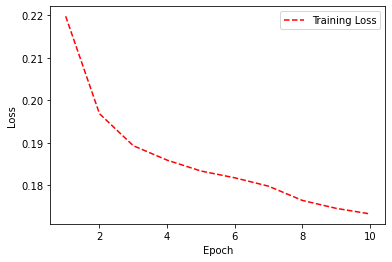

In [ ]:
# Visualize loss history

# Get training and validation loss histories
loss = hist.history["loss"]
#validation_loss = hist.history["val_loss"]

# Create count of the number of epochs
epoch_count = range(1, len(loss) + 1)

# Plot the results
plt.plot(epoch_count, loss, "r--")
#plt.plot(epoch_count, validation_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()